We want to model a layered permeability field using a Gaussian Process and KLE subject to a few observations (engineers have drilled the ground and measure permeability at some points). We use ARD to maximimize the liklihood, this gives us the lenghtscales and variation for the GP kernel.

In [12]:
class PermeabilityModel(object):

    """
    A stochastic model for permeability.

    :param X1:  x coordinates of grid
    :param X2:  y coordinates of grid
    :param X3:  z coordinates of grid
    :param cov: a covariance function
    :param K0:  a geometric mean level for the field
    :param X:   observed inputs
    :param Y:   observed outputs
    """

    def __init__(self, X1, X2, X3, cov, mu0=0., X=None, Y=None, nugget=1e-12):
        self.cov = cov
        self.X1 = X1
        self.X2 = X2
        self.X3 = X3
        n = np.prod(X1.shape)
        self.n = n
        self.mu0 = mu0
        self.X_all = np.hstack([X1.flatten()[:, None], X2.flatten()[:, None], X3.flatten()[:, None]])
        if X is not None:
            CX = cov.K(X) + nugget * np.eye(X.shape[0])
            L = np.linalg.cholesky(CX)
            self.LiY = np.linalg.solve(L, Y - mu0)
            CXaX = cov.K(self.X_all, X)
            self.G0 = self.mu0 + np.dot(CXaX, self.LiY).reshape(self.X1.shape)
            self.C = cov.K(self.X_all) - np.dot(CXaX, CXaX.T) + nugget * np.eye(self.X_all.shape[0])
        else:
            self.C = cov.K(self.X_all) + nugget * np.eye(self.X_all.shape[0])
            self.G0 = np.ones(self.X1.shape) * mu0
        self.L = np.linalg.cholesky(self.C)

    def sample(self):
        """
        Sample the model.
        """
        g = np.dot(self.L, np.random.randn(self.L.shape[0]))
        G = g.reshape(self.X1.shape)
        return self.G0 + G

In [ ]:
class KarhunenLoeveExpansion(object):
    
    """
    A class representing the Karhunen Loeve Expansion of a Gaussian random field.
    It uses the Nystrom approximation to do it.
    
    Arguments:
        k      -     The covariance function.
        Xq     -     Quadrature points for the Nystrom approximation.
        wq     -     Quadrature weights for the Nystrom approximation.
        alpha  -     The percentage of the energy of the field that you want to keep.
        X      -     Observed inputs (optional).
        Y      -     Observed field values (optional).
    """
    
    def __init__(self, k, Xq=None, wq=None, nq=100, alpha=0.9, X=None, Y=None):
        self.k = k
        if Xq is None:
            if k.input_dim == 1:
                Xq = np.linspace(0, 1, nq)[:, None]
                wq = np.ones((nq, )) / nq
            elif k.input_dim == 2:
                #nq = int(np.sqrt(nq))
                x = np.linspace(0, 1, nq)
                X1, X2 = np.meshgrid(x, x)
                Xq = np.hstack([X1.flatten()[:, None], X2.flatten()[:, None]])
                wq = np.ones((nq ** 2, )) / nq ** 2
            elif k.input_dim == 3:
                #nq = int(cbrt(nq))
                x = np.linspace(0, 1, nq)
                X1, X2, X3 = np.meshgrid(x, x, x)
                Xq = np.hstack([X1.flatten()[:, None], X2.flatten()[:, None], X3.flatten()[:, None]])
                wq = np.ones((nq ** 3, )) / nq ** 3                
            else:
                raise NotImplementedError('For more than 3D, please supply quadrature points and weights.')
        self.Xq = Xq
        self.wq = wq
        self.k = k
        self.alpha = alpha
        self.X = X
        self.Y = Y
        # If we have some observed data, we need to use the posterior covariance
        if X is not None:
            self.K = self.k.K(X) + 1e-12 * np.eye(X.shape[0])
            self.L = np.linalg.cholesky(self.K)
            self.LiY = np.linalg.solve(self.L, Y)
            Kqp = self.k.K(Xq)
            Kcp = self.k.K(X, Xq)
            self.LiKcp = np.linalg.solve(self.L, Kcp)
            Kq = Kqp - np.dot(self.LiKcp.T, self.LiKcp)
            #gpr = GPy.models.GPRegression(X, Y[:, None], k)
            #gpr.likelihood.variance = 1e-12
            #self.gpr = gpr
            #Kq = gpr.predict(Xq, full_cov=True)[1]
        else:
            Kq = k.K(Xq)
        B = np.einsum('ij,j->ij', Kq, wq)
        lam, v = scipy.linalg.eigh(B, overwrite_a=True)
        lam = lam[::-1]
        lam[lam <= 0.] = 0.
        energy = np.cumsum(lam) / np.sum(lam)
        i_end = np.arange(energy.shape[0])[energy > alpha][0] + 1
        lam = lam[:i_end]
        v = v[:, ::-1]
        v = v[:, :i_end]
        self.lam = lam
        self.sqrt_lam = np.sqrt(lam)
        self.v = v
        self.energy = energy
        self.num_xi = i_end
        self.x_prev = None

    def eval_phi(self, x):
        """
        Evaluate the eigenfunctions at x.
        """
        if self.X is not None:
            KXx = self.k.K(self.X, x)
            LiKXx = np.linalg.solve(self.L, KXx)
            m = np.dot(LiKXx.T, self.LiY)
            Kc = self.k.K(x, self.Xq) - np.dot(LiKXx.T, self.LiKcp)
            self.tmp_mu = m
        else:
            Kc = self.k.K(x, self.Xq)
            self.tmp_mu = 0.
        phi = np.einsum('i,ji,j,rj->ri', 1. / self.lam, self.v, self.wq, Kc)
        return phi
    
    def __call__(self, x, xi):
        """
        Evaluate the expansion at x and xi.
        """
        if self.x_prev is not x:
            self.x_prev = x
            self.tmp_phi = self.eval_phi(x)
        print self.tmp_mu
        return self.tmp_mu + np.dot(self.tmp_phi, xi * self.sqrt_lam)

In [2]:
# importing all the necessary packages
import io
import cPickle as pickle
import numpy as np
import scipy
import GPy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
import scipy.linalg 
from scipy.special import cbrt
import os
import shutil

In [3]:
# problem parameters
x1_L = 50. 
x2_L = 50.
x3_L = 30. # depth
Nx = 10 #20
Ny = 10 #20
Nz = 15 #25    # layers in depth !this is also eual to num_obs for wells

numSamples = 2

x1 = np.linspace(0, 1, Nx)
x2 = np.linspace(0, 1, Ny)
x3 = np.linspace(0, 1, Nz)
X1, X2, X3 = np.meshgrid(x1, x2, x3)
#X_all = np.hstack([X3.flatten()[:, None]])
X_all = np.hstack([x3.flatten()[:, None]])
#print x3
#print np.hstack([X3.flatten()[:, None]])
#print X_all
#print x3[:, None]

In [4]:
# importing observed data, calculating cell-centers 
well_num = 2
dim = 3
# we load well data here
well1_data = np.loadtxt('data/well1.txt') #depth Kx Ky Kz porosity 
well2_data = np.loadtxt('data/well2.txt') #depth Kx Ky Kz porosity 
#converting well data 
well1_data[:,1:-1] = np.log10(1e-3*9.869233e-13*well1_data[:,1:-1])
##well1_data[:,4] = (1e-2*well1_data[:,4])
well1_data[:,4] = np.log10(1e-2*well1_data[:,4])
well2_data[:,1:-1] = np.log10(1e-3*9.869233e-13*well2_data[:,1:-1])
##well2_data[:,4] = (1e-2*well2_data[:,4])
well2_data[:,4] = np.log10(1e-2*well2_data[:,4])
# we model the fixed depth reservoir, thus we eliminate the extra information for well2 (min function)
num_obs = well_num*min(len(well1_data),len(well2_data)) #if more wells add here
X_obs = np.zeros ((num_obs, dim)) # (num_obs, dim) r = x1,x2,x3   
Y_obs = np.zeros ((num_obs, 4))  # (num_obs, unknown parameters:Kx,Ky,Kz,porosity)                 
# calculating cell-centers
xc = np.zeros((Nx,Ny,Nz))
yc = np.zeros((Nx,Ny,Nz))
zc = np.zeros((Nx,Ny,Nz))
for i in range(0,Nx):
  for j in range(0,Ny):
    for k in range(0,Nz):
        xc[i,j,k] = (i+0.5)*x1_L/Nx/x1_L #we divide by x1_L to normalize xc
        yc[i,j,k] = (j+0.5)*x2_L/Ny/x2_L
        zc[i,j,k] = (k+0.5)*x3_L/Nz/x3_L
# we construct the observation coordinates and values here in X_obs and Y_obs, respectively 
# well1[i,j,k] --> 0,0,0-14, well2[i,j,k] --> 9,9,0-14
for k in range(0,int(0.5*num_obs)): # we sweep along well1 in z
    X_obs[k,:] = [xc[0,0,k],yc[0,0,k],zc[0,0,k]]
    Y_obs[k,:] = well1_data[k,1:5]
for k in range(int(0.5*num_obs),num_obs): # we sweep along well2 in z
    X_obs[k,:] = [xc[9,9,k-int(0.5*num_obs)],yc[9,9,k-int(0.5*num_obs)],zc[9,9,k-int(0.5*num_obs)]]
    Y_obs[k,:] = well2_data[k-int(0.5*num_obs),1:5]
#print X_obs
#print Y_obs

# we only model out stochastic fields as a function of depth --> no variation in xy plane
Y1_obs = Y_obs[0:15,:]
Y2_obs = Y_obs[15:30,:]
Y_obs_1D = 0.5*(Y1_obs + Y2_obs)
X_obs_1D = X_obs[0:15,2:3] 
#print X_obs_1D.shape
#print Y_obs_1D.shape
#print Y_obs_1D
#print X_obs_1D
#print x3

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
# First, let's fit a Gaussian process to the data.
# This will automatically determine the best lengthscale and variance by maximizing the likelihood
k1 = GPy.kern.Exponential(1, ARD=True)
#k1.lengthscale.constrain_fixed([0.1, 0.1, 0.1])
k_permX = k1
# There are not enough data to find the X and Y length scales. We need to fix their values to the 
# persumed variability.
# Center the data about 0
m0 = Y_obs_1D.mean(axis=0)
print X_obs_1D.shape
print Y_obs_1D[:,0:1].shape
#print Y_obs_1D[:,0:1]
#print pow(10., Y_obs_1D[:,0:1])/(1e-3*9.869233e-13)

model_permX = GPy.models.GPRegression(X_obs_1D, Y_obs_1D[:,0:1]-m0[0], k_permX)
# We do not want the field to have any noise
model_permX.likelihood.variance.constrain_fixed(1e-2) #I intentionally chose this large value to allow variety
# Let the GP optimize for just the variance of the kernel
model_permX.optimize()
print str(model_permX)

(15, 1)
(15, 1)

Name : GP regression
Objective : 1.71027915829
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  Exponential.variance     |   0.06354638645536606  |      +ve      |        
  Exponential.lengthscale  |  0.004003794870366442  |      +ve      |        
  Gaussian_noise.variance  |                  0.01  |   +ve fixed   |        


nq = 2300, num_terms = 921


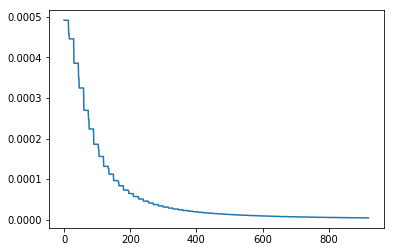

In [8]:
# Alternatively, let's use the Nystrom to the KLE.
# nq controls the accuracy of the approximation (number of quadrature points per dimension)
# We must start low and keep increasing it, until the approximation does not change
fig, ax = plt.subplots()
#for nq in [2, 4, 8, 16, 32]:
for nq in [2300]:
    # Notice that here I give the kernel with the optimized parameters                    
    kle_permX = KarhunenLoeveExpansion(model_permX.kern, nq=nq, alpha=0.95, X=X_obs_1D, Y=Y_obs_1D[:,0:1]-m0[0])
    print 'nq = {0:d}, num_terms = {1:d}'.format(nq, kle_permX.num_xi)
    ax.plot(kle_permX.lam)

In [11]:
Kx = kle_permX(X_obs_1D, np.random.randn(kle_permX.num_xi)) + m0[0] # Remember to add back the constant mean
print Kx.shape
# print pow(10., (Kx)[:,0:1])/(1e-3*9.869233e-13)
# print pow(10., Kx[:,0])/(1e-3*9.869233e-13)
# print pow(10., Y_obs_1D[:,0])/(1e-3*9.869233e-13)

[[-0.08995853]
 [-0.32010083]
 [ 0.52384169]
 [-0.06968026]
 [ 0.36458004]
 [ 0.25160153]
 [-0.08838338]
 [-0.18918006]
 [-0.34412846]
 [-0.0935554 ]
 [ 0.41645457]
 [-0.04261461]
 [ 0.15582509]
 [-0.10664101]
 [-0.36806038]]
(15, 15)


[-12.50448779 -12.74385677 -11.90580744 -12.52630083 -12.18721616
 -11.98913225 -12.58385431 -12.59822416 -12.55993891 -12.48225941
 -12.05264395 -12.58352964 -12.14020566 -12.91148818 -12.61217382]
399.5473810317393


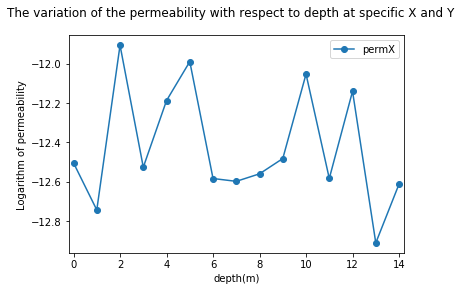

In [10]:
#Kx = model_permX.posterior_samples_f(X_all)[:,0] + m0[0]
#Kx = model_permX.posterior_samples_f(X_obs_1D)[:,0] + m0[0]
Kx = model_permX.posterior_samples(X_obs_1D)[:,0] + m0[0]
#Kx = pow(10., Kx)/(1e-3*9.869233e-13)  #printing Kx in md
print Kx
print pow(10., m0[0])/(1e-3*9.869233e-13) # printing Kx_mean in md 

fig, ax = plt.subplots()
ax.plot(Kx,marker='o',label='permX')
fig.suptitle('The variation of the permeability with respect to depth at specific X and Y')
plt.xlabel('depth(m)')
plt.ylabel('Logarithm of permeability')
plt.legend()
plt.xlim(-.2,14.2)
plt.savefig('sampledPermXDepth.pdf')